## CIFAR-10 Data Preprocessing for Hopfield Networks and Phase Space Learning

### Step 1: Install and Import Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import importlib
import random

import hopfield_baseline
import hopfield_PSL
import storkey
import spiking
import grayscaled_hp_baseline

### Step 2: Load the CIFAR-10 Dataset

In [2]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

# Create directory to save grayscale images
save_dir = 'data/grayscale_images'
os.makedirs(save_dir, exist_ok=True)

# Save grayscale images as NumPy arrays
grayscale_images = [img.numpy() for img, _ in train_dataset]
grayscale_images_np = np.array(grayscale_images)
np.save(os.path.join(save_dir, "train_images.npy"), grayscale_images_np)

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000


In [3]:
def encode(img):
    """
    Encodes a grayscale image (0-255) into a binary representation (-1,1).
    
    Args:
        img (torch.Tensor): Grayscale image of shape (H, W), values in [0, 255].
    
    Returns:
        torch.Tensor: Encoded binary vector of shape (H*W*8,), values in {-1,1}.
    """
    img = img * 255 if img.max() <= 1 else img
    flat = img.flatten()
    flat_np = flat.numpy().astype(np.uint8)
    bits = np.unpackbits(flat_np.reshape(-1, 1), axis=1)
    encoded = 2 * bits - 1  # Convert {0,1} -> {-1,1}
    encoded_flat = encoded.flatten()
    return torch.tensor(encoded_flat, dtype=torch.int8)

def decode(encoded):
    """
    Decodes a binary vector (-1,1) back into a grayscale image (0-255).
    
    Args:
        encoded (torch.Tensor): Encoded binary vector of shape (H*W*8,), values in {-1,1}.
    
    Returns:
        torch.Tensor: Decoded grayscale image of shape (H, W), values in [0, 255].
    """
    if isinstance(encoded, torch.Tensor):
        encoded_reshaped = encoded.reshape(-1, 8)
        bits = ((encoded_reshaped + 1) // 2).numpy().astype(np.uint8)  # Convert {-1,1} -> {0,1}
    else:  # Assuming encoded is a numpy array
        encoded_reshaped = encoded.reshape(-1, 8)
        bits = ((encoded_reshaped + 1) // 2).astype(np.uint8)  # Convert {-1,1} -> {0,1}
    
    pixels = np.packbits(bits, axis=1)
    pixels = pixels.squeeze(1)
    
    img = torch.from_numpy(pixels).reshape(32, 32)  # Assuming a 32x32 image
    return img


# Load saved grayscale images
stored_images_np = np.load("data/grayscale_images/train_images.npy")
stored_images = torch.tensor(stored_images_np, dtype=torch.float32)

# Encode grayscale images into binary representation (-1, 1)
encoded_images = torch.stack([encode(img) for img in stored_images])

tensor([[-1, -1,  1,  ..., -1,  1,  1],
        [ 1, -1,  1,  ..., -1, -1,  1],
        [ 1,  1,  1,  ...,  1, -1, -1],
        ...,
        [ 1, -1, -1,  ..., -1,  1,  1],
        [ 1,  1, -1,  ...,  1, -1,  1],
        [ 1,  1,  1,  ..., -1,  1,  1]], dtype=torch.int8)


### Step 6: Visualize Some Grayscaled Images

Text(0.5, 1.0, 'Grayscale Images ')

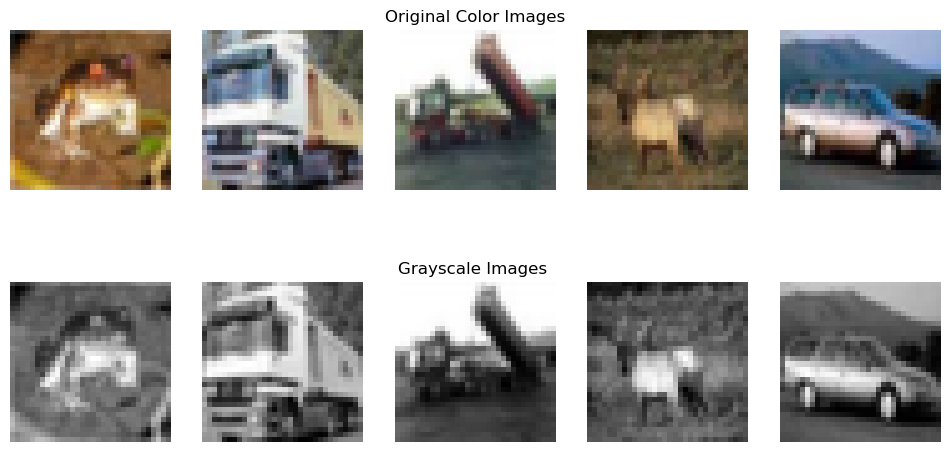

In [4]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    grayscale_image = stored_images[i].squeeze(0)
    axes[1, i].imshow(grayscale_image.reshape(32,32), cmap='gray')
    axes[1, i].axis('off')

axes[0, num_images // 2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1, num_images // 2].set_title('Grayscale Images ', fontsize=12, loc='center')

### Step 7: Generate a Corrupted Subset of Training Images

In [5]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    if isinstance(images, torch.Tensor):
        images = images.numpy()
        
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [6]:
# create corrupted images to use as test set
masked_images = corrupt_images(encoded_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(encoded_images, corruption_type='flip', corruption_fraction=0.25)

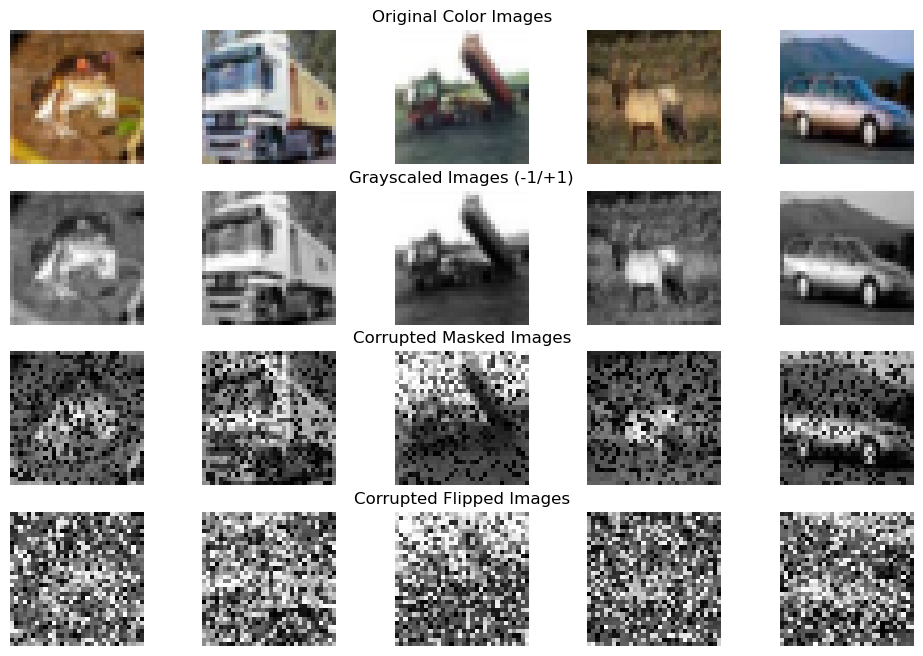

In [7]:
# Visualize some corrupted images
num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot grayscaled images   
    axes[1,i].imshow(stored_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(decode(masked_images[i]).reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(decode(flipped_images[i]).reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Grayscaled Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')

plt.show()

### Step 8: Save the Preprocessed Datasets

In [8]:
# Save corrupted data
np.save("data/grayscale_images/masked_images.npy", masked_images)
np.save("data/grayscale_images/flipped_images.npy", flipped_images)

## Training Baseline

In [9]:
# Reload for training
stored_images = torch.tensor(np.load("data/grayscale_images/train_images.npy"), dtype=torch.float32)
masked_images = torch.tensor(np.load("data/grayscale_images/masked_images.npy"), dtype=torch.float32)
flipped_images = torch.tensor(np.load("data/grayscale_images/flipped_images.npy"), dtype=torch.float32)

In [10]:
importlib.reload(grayscaled_hp_baseline)

num_neurons = 8192
num_patterns = 50
hopfield_rnn = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = encoded_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_rnn.store_patterns(baseline_original)

In [11]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_rnn(baseline_masked)
retrieved_flipped = hopfield_rnn(baseline_flipped)

In [12]:
# Decode retrieved images for visualization
decoded_original = [decode(img) for img in baseline_original]
decoded_masked = [decode(img) for img in retrieved_masked]
decoded_flipped = [decode(img) for img in retrieved_flipped]

In [13]:
# Compute SSE Loss
loss_masked = hopfield_rnn.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_rnn.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction SSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction SSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_rnn.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_rnn.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction SSE Loss (Masked Images): 419326.0000
Reconstruction SSE Loss (Flipped Images): 437629.0000
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 0.5400
Reconstruction Accuracy (Flipped Images): 0.5400


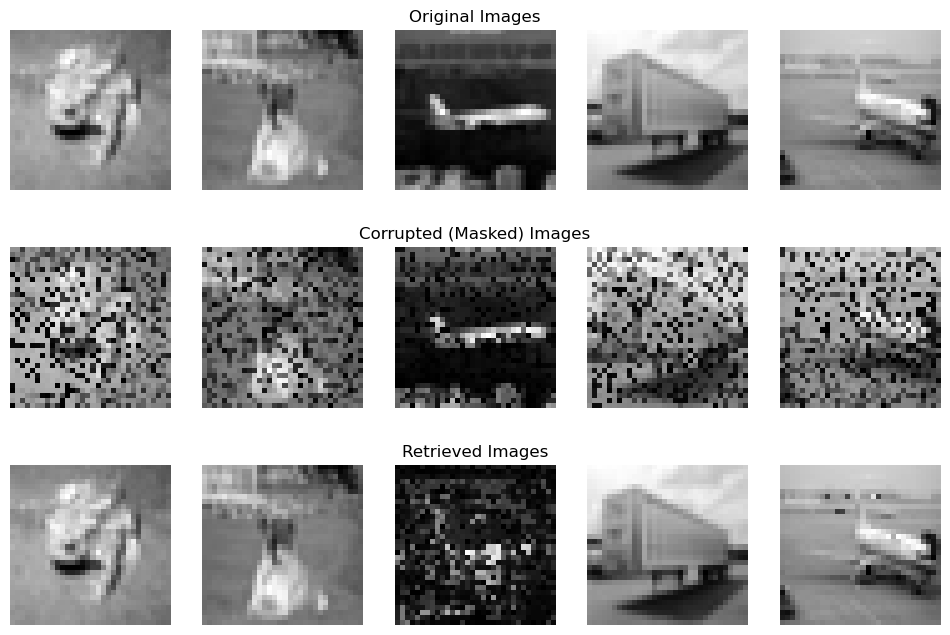

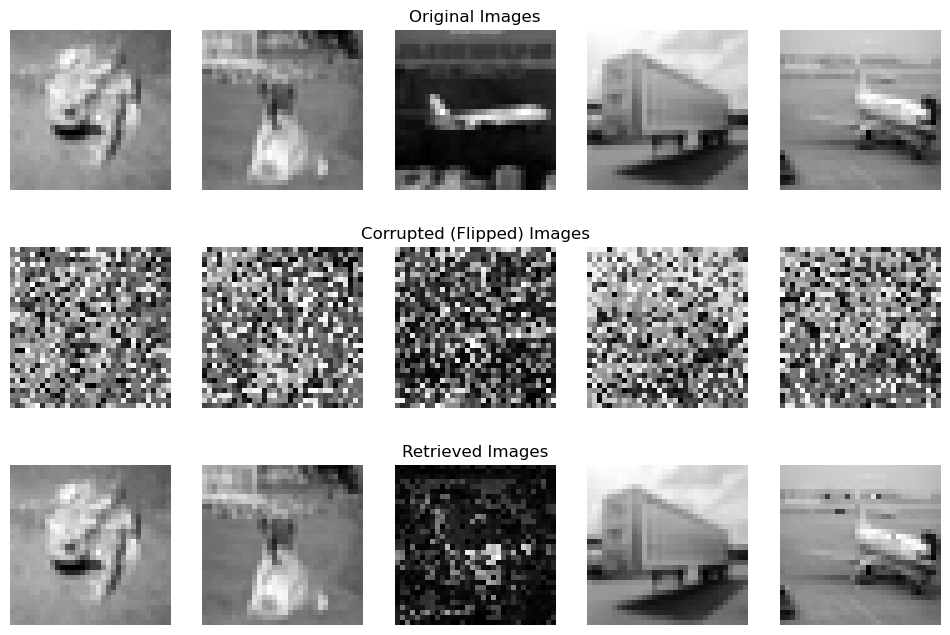

In [14]:
def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Decode the original image back to grayscale before reshaping
        decoded_original = decode(original[i])   # Decode the image
        axes[0, i].imshow(decoded_original, cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        corrupted_image_rescaled = decode(corrupted[i])  # Reshape to 2D
        axes[1, i].imshow(corrupted_image_rescaled, cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        retrieved_image_rescaled = decode(retrieved[i])  # Reshape to 2D
        axes[2, i].imshow(retrieved_image_rescaled, cmap='gray')
        axes[2, i].axis('off')

    axes[0, num_samples // 2].set_title('Original Images', fontsize=12, loc='center')
    axes[1, num_samples // 2].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, num_samples // 2].set_title(title_retrieved, fontsize=12, loc='center')
    
    plt.show()

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")


### Reconstructing Images for Increasing Stored Patterns

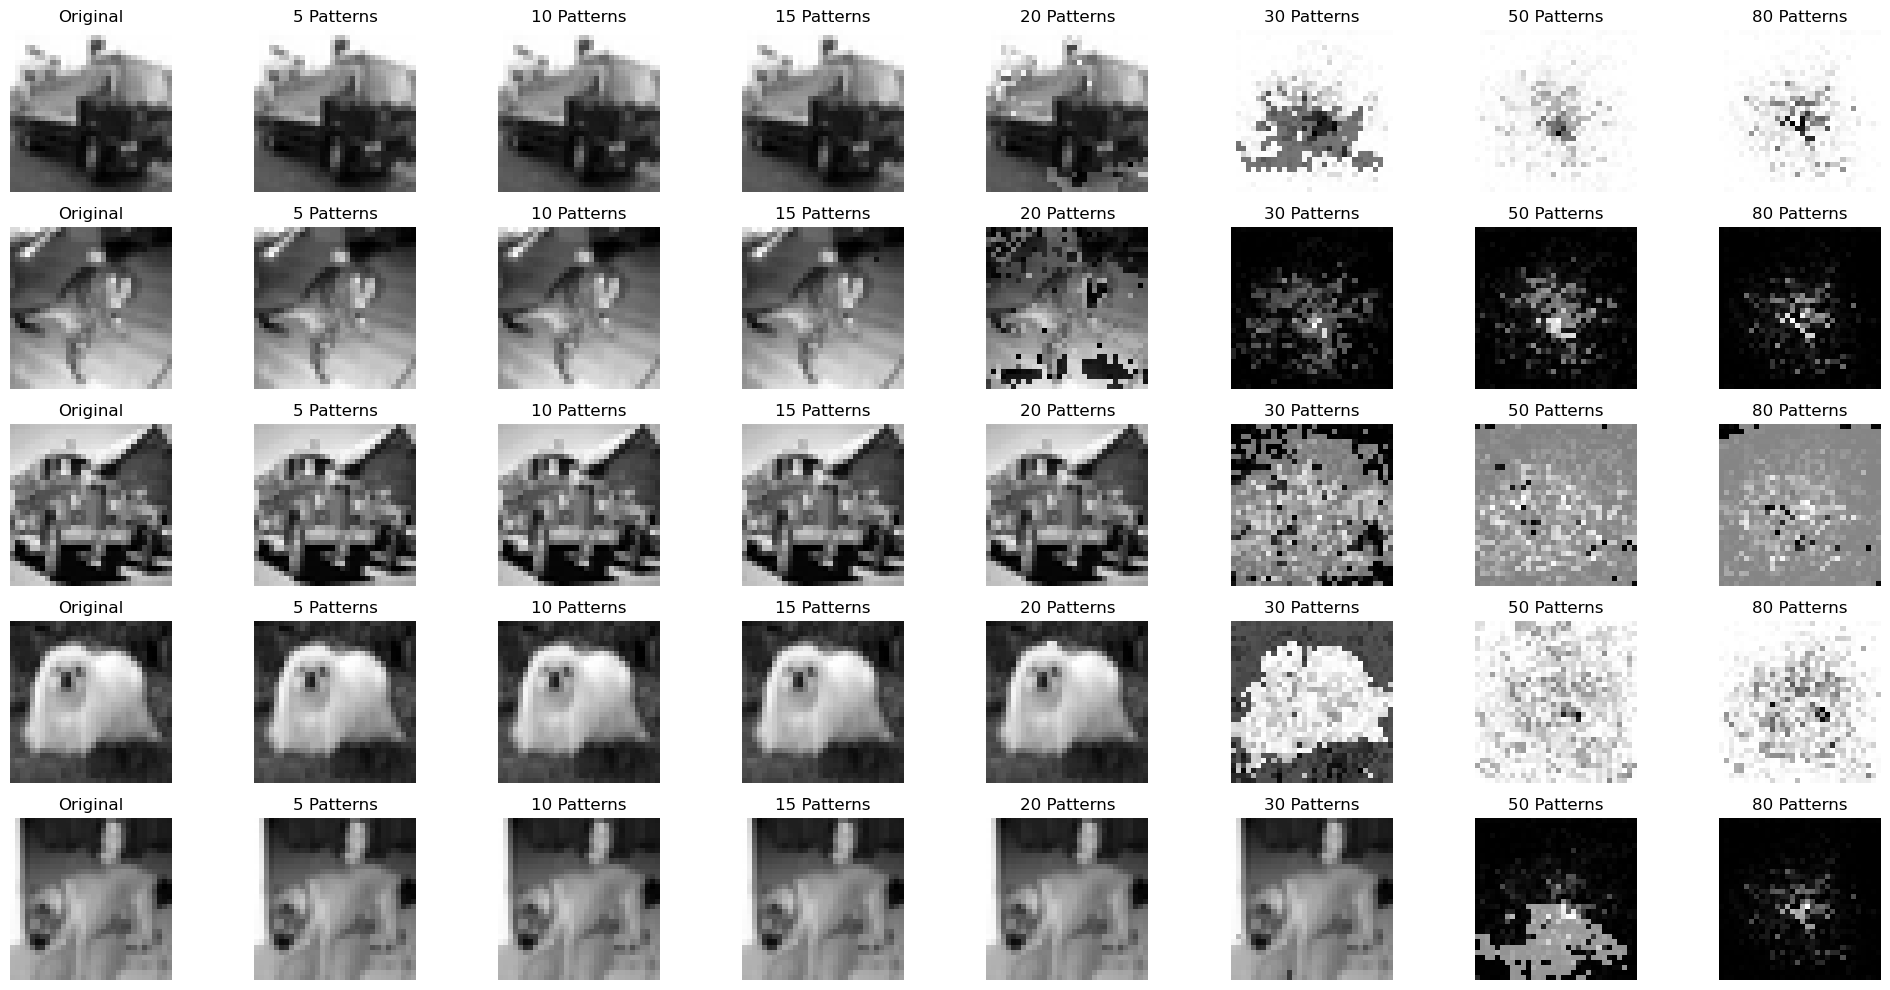

In [16]:
results = []
num_patterns_list = [5, 10, 15, 20, 30, 50, 80]
selected_idxs = set()
plot_idx = []

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_rnn = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = encoded_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_rnn.store_patterns(baseline_original)

    retrieved_masked = hopfield_rnn(baseline_masked)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = decode(results[i][row-1]).reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


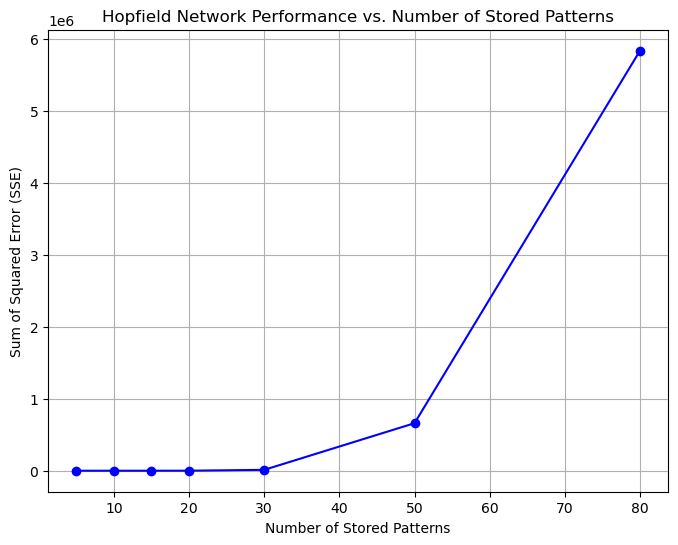

In [17]:

results = []
sse_values = []
num_patterns_list = [5, 10, 15, 20, 30, 50, 80]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_rnn = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = encoded_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_rnn.store_patterns(baseline_original)

    retrieved_masked = hopfield_rnn(baseline_masked)
    loss = hopfield_rnn.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())
    sse_values.append(loss.detach().numpy())

    
# Plot the SSE curve
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, sse_values, marker='o', linestyle='-', color='b')
plt.title("Hopfield Network Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Sum of Squared Error (SSE)")
plt.grid(True)
plt.show()


### Recalling Increasing Number of Patterns